In [100]:
from py2neo import Graph
graph = Graph("bolt://localhost:7687", auth=("neo4j", ""))

In [91]:
import json

allArticles = {}
with open("article_analysis_final_v2.json") as file:
    articles = json.load(file)
    cnt = 0
    for article in articles:
        allArticles[article] = articles[article]
        cnt+=1
        # if cnt > 1000:
        #     break
    


In [92]:
graph.run("MATCH (n) DETACH DELETE n")
cnt = 0
no_keywords = 0
for url, info in allArticles.items():
    if "keywords" not in info:
        no_keywords+=1
        continue
    keywords = info["keywords"]
    for keyword in keywords:
        # if len(r) < 2 or r[1] == None:
        #     print(r)
        #     continue
        # keyword = r[1]
        # keyword = keyword.replace("'", "").replace('"', "").replace("\\", "")
        # if keyword[2].contains(" "):
        #     keyword_name = 
        #     for name in keyword_name:
        #         graph.run(f"MERGE (n:Keyword {{name: '{name}'}})")
        # else:
        graph.run(f"MERGE (n:Keyword {{name: '{keyword}'}})")
    cnt+=1    
    
print(f"No keywords: {no_keywords}")

No keywords: 1126


In [ ]:
cnt = 0
for url, info in allArticles.items():
    if "keywords" not in info:
        continue
    keywords = info["keywords"]
    for keyword in keywords:
        # if len(r) < 2 or r[1] == None:
        #     print(r)
        #     continue
        # keyword = r[1]
        # keyword = keyword.replace("'", "").replace('"', "").replace("\\", "")

        sentiment = "NEU"
        if 'sentiment' in info:
            sentiment = info['sentiment']
            if sentiment == "positive":
                sentiment = "POS"
            elif sentiment == "negative":   
                sentiment = "NEG"
            else:
                sentiment = "NEU"

            dateStr = info['date'].split(' ')[0]
            dateStr = dateStr.split('T')[0]
            graph.run(f"MERGE (a:Article:{sentiment}{{url: '{url}', title: '{info['title']}', sentiment: '{sentiment}', date: date('{dateStr}')}})")
        else:
            graph.run(f"MERGE (a:Article:{sentiment}{{url: '{url}', title: '{info['title']}', date: date('{dateStr}')}})")
        cmd = f"MATCH (k:Keyword {{name: '{keyword}'}}), (a:Article:{sentiment}{{url: '{url}'}}) MERGE (a)-[:HAS_KEYWORD]->(k)"
        graph.run(cmd)
    cnt+=1    
    print(cnt)

In [102]:
# Link keywords sharing the same article
run = graph.run(f'''MATCH (a:POS)-[:HAS_KEYWORD]->(k1:Keyword)
MATCH (a)-[:HAS_KEYWORD]->(k2:Keyword)
WHERE id(k1) < id(k2)  // Ensure each pair is only counted once
WITH k1, k2, COUNT(a) AS sharedArticleCount
MERGE (k1)-[r:SHARES_POS_ARTICLE]-(k2)
SET r.weight = sharedArticleCount''')  
print(run)

# Link keywords sharing the same article
run = graph.run(f'''MATCH (a:NEG)-[:HAS_KEYWORD]->(k1:Keyword)
MATCH (a)-[:HAS_KEYWORD]->(k2:Keyword)
WHERE id(k1) < id(k2)  // Ensure each pair is only counted once
WITH k1, k2, COUNT(a) AS sharedArticleCount
MERGE (k1)-[r:SHARES_NEG_ARTICLE]-(k2)
SET r.weight = sharedArticleCount''')  
print(run)




(No data)
(No data)


In [98]:
# Link articles sharing the same keywords
run = graph.run(f'''MATCH (a1:POS)-[:HAS_KEYWORD]->(k:Keyword)<-[:HAS_KEYWORD]-(a2:POS)
WHERE id(a1) < id(a2)  
WITH a1, a2, COUNT(k) AS sharedKeywordCount
MERGE (a1)-[r:SHARES_KEYWORDS_POS]-(a2)
SET r.weight = sharedKeywordCount''')  
print(run)
run = graph.run(f'''MATCH (a1:NEG)-[:HAS_KEYWORD]->(k:Keyword)<-[:HAS_KEYWORD]-(a2:NEG)
WHERE id(a1) < id(a2)  
WITH a1, a2, COUNT(k) AS sharedKeywordCount
MERGE (a1)-[r:SHARES_KEYWORDS_NEG]-(a2)
SET r.weight = sharedKeywordCount''')  
print(run)

(No data)
(No data)


In [104]:
# Check keywords influence for positive articles
graph_name = "pagerank_keywords"
cmd = f'''CALL gds.graph.exists("{graph_name}")
  YIELD graphName, exists
RETURN graphName, exists'''

result = graph.run(cmd)
for row in result:
    if row['exists'] == True:
        graph.run(f"CALL gds.graph.drop('{graph_name}')")

cmd = f'''MATCH (source:Keyword)-[r:SHARES_POS_ARTICLE]-(target:Keyword)
RETURN gds.graph.project(
  '{graph_name}',
  source,
  target,
  {{ relationshipProperties: r {{ .weight }} }}
)'''

result = graph.run(cmd)


cmd = f'''CALL gds.pageRank.stream('{graph_name}')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score
ORDER BY score DESC, name ASC
LIMIT 20'''
result = graph.run(cmd)
for row in result:
    if row['name'] != None:
        print(row['name'], row['score'])


# print("--------------------------------")
# # Check keywords influence for negative articles
# graph_name = "pagerank_keywords"
# cmd = f'''CALL gds.graph.exists("{graph_name}")
#   YIELD graphName, exists
# RETURN graphName, exists'''

# result = graph.run(cmd)
# for row in result:
#     if row['exists'] == True:
#         graph.run(f"CALL gds.graph.drop('{graph_name}')")

# cmd = f'''MATCH (:NEG)-[:HAS_KEYWORD]->(source:Keyword)-[r:SHARES_ARTICLE]-(target:Keyword)<-[:HAS_KEYWORD]-(:NEG)
# RETURN gds.graph.project(
#   '{graph_name}',
#   source,
#   target,
#   {{ relationshipProperties: r {{ .weight }} }}
# )'''

# result = graph.run(cmd)


# cmd = f'''CALL gds.pageRank.stream('{graph_name}', {{
#   maxIterations: 200,
#   dampingFactor: 0.85,
#   relationshipWeightProperty: 'weight'
# }})
# YIELD nodeId, score
# RETURN gds.util.asNode(nodeId).name AS name, score
# ORDER BY score DESC, name ASC
# LIMIT 20'''
# result = graph.run(cmd)
# for row in result:
#     if row['name'] != None:
#         print(row['name'], row['score'])

print("--------------------------------")
# Check keywords influence for negative articles
graph_name = "pagerank_keywords"
cmd = f'''CALL gds.graph.exists("{graph_name}")
  YIELD graphName, exists
RETURN graphName, exists'''

result = graph.run(cmd)
for row in result:
    if row['exists'] == True:
        graph.run(f"CALL gds.graph.drop('{graph_name}')")

cmd = f'''MATCH (source:Keyword)-[r:SHARES_NEG_ARTICLE]-(target:Keyword)
RETURN gds.graph.project(
  '{graph_name}',
  source,
  target,
  {{ relationshipProperties: r {{ .weight }} }}
)'''

result = graph.run(cmd)


cmd = f'''CALL gds.pageRank.stream('{graph_name}', {{
  maxIterations: 200,
  dampingFactor: 0.85,
  relationshipWeightProperty: 'weight'
}})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score
ORDER BY score DESC, name ASC
LIMIT 20'''
result = graph.run(cmd)
for row in result:
    if row['name'] != None:
        print(row['name'], row['score'])


keywordListBoth = ['covid', 'coronavirus','news','pandem','say']
keywordListPos = ['covid', 'coronavirus','help','reopen','busi','open','lockdown','support','world','market','time','home','announc','launch','plan','local','black']
keywordListNeg = ['case', 'virus','trump','death','report','protest','state','amid','face','test','polic','health','rise','warn','fear']


covid 50.97736170520805
news 31.735995610963204
coronavirus 28.640548008898616
help 22.2467338390534
pandem 19.636168323738097
reopen 18.63357064666513
busi 18.398459645030552
open 16.798377746348855
lockdown 15.995886076789185
support 14.809227654471954
world 14.543647761007426
market 14.400679224676516
time 13.555226530318727
home 13.062556327522312
announc 12.987052320077899
launch 12.952179095968267
plan 12.304087166902614
say 12.090544104901836
local 11.711023380146056
black 10.864365777559614
--------------------------------
covid 114.10590861745789
coronavirus 88.87580103054607
case 53.6293774649791
virus 41.20102169892756
trump 38.72358054376683
news 38.60075041951764
death 34.172966140793925
pandem 33.48845065356378
say 32.603093960615944
report 28.659403222133804
protest 25.45097486031292
state 21.18572051564007
amid 20.38896658261643
face 19.497350577640788
test 19.00467369175084
polic 17.848977024154213
health 17.51376792027552
rise 17.081101703766315
warn 16.34457988860728

In [106]:
# find clustter of articles sharing the same keywords
graph_name = "cluster_pos_article_by_keyword"
cmd = f'''CALL gds.graph.exists("{graph_name}")
  YIELD graphName, exists
RETURN graphName, exists'''

result = graph.run(cmd)
for row in result:
    if row['exists'] == True:
        graph.run(f"CALL gds.graph.drop('{graph_name}')")

cmd=f'''MATCH (k1:Keyword{{name:"reopen"}})<-[:HAS_KEYWORD]-(source:Article)-[r:SHARES_KEYWORDS_NEG]-(target:Article)-[:HAS_KEYWORD]->(k2:Keyword{{name:"reopen"}})
RETURN gds.graph.project(
  '{graph_name}',
  source,
  target,
  {{relationshipProperties: r {{ .weight  }}  }},
  {{ undirectedRelationshipTypes: ['*'] }}
)'''
result = graph.run(cmd)


cmd=f'''CALL gds.louvain.stream('{graph_name}', {{ relationshipWeightProperty: 'weight' }})
YIELD nodeId, communityId, intermediateCommunityIds
RETURN gds.util.asNode(nodeId).title AS name, communityId
ORDER BY name ASC'''
result = graph.run(cmd)
communities = {}
for row in result:
    community_id = row['communityId']
   
    if community_id not in communities:
      print(f"Community {community_id}")
      communities[community_id] = []
    communities[community_id].append(row['name'])

for community_id, names in communities.items():
    print(f"\nCommunity {community_id}:")
    for name in names:
        print(f"  {name}")



Community 54
Community 49
Community 14
Community 56

Community 54:
  1.9 million seek jobless aid even as reopenings slow layoffs
  AMC pushes back movie theater reopening by 2 weeks
  Alameda County barber shops frustration grows with reopening date still not scheduled
  Back to school? 1 in 5 teachers are unlikely to return to reopened classrooms this fall poll says - News - Alice Echo News-Journal
  Beijing outbreak shows need to be ready as economies reopen
  Brazil virus deaths top 40000 as Europe prepares to reopen borders
  Calls grow to reopen parts of Zimbabwes crisis-ridden economy
  Central Maine gym owners chafe at restrictions await reopening decision
  China virus cluster grows as European borders reopen
  Cineplex plans to reopen cinemas while shares suffer over failed Cineworld deal
  Crater Lake National Park reopening remains uncertain
  Customers face long wait as BMV reopens
  Disney delays Southern California theme park reopenings
  Education secretary confirms pri

In [107]:
import time
from datetime import datetime 

# # connect articles with the same sentiments -> too much instant
# print("Starting POS-POS connections:", datetime.now())
# start_time = time.time()
# graph.run(f"MATCH (a1:POS), (a2:POS) MERGE (a1)-[:SAME_POS_SENTIMENT]-(a2)")
# print(f"POS-POS connections completed in {time.time() - start_time:.2f} seconds")

# print("Starting NEG-NEG connections:", datetime.now()) 
# start_time = time.time()
# graph.run(f"MATCH (a1:NEG), (a2:NEG) MERGE (a1)-[:SAME_NEG_SENTIMENT]-(a2)")
# print(f"NEG-NEG connections completed in {time.time() - start_time:.2f} seconds")

# mark sentiment shift NEG-POS keywords
print("Starting NEG-POS shift marking:", datetime.now())
start_time = time.time()
cmd = f'''MATCH (a1:NEG)-[:HAS_KEYWORD]->(k:Keyword)<-[:HAS_KEYWORD]-(a2:POS)
WHERE a1.date < a2.date
WITH DISTINCT k
SET k:NEG_POS_SHIFT_KEYWORD'''
graph.run(cmd)
print(f"NEG-POS shift marking completed in {time.time() - start_time:.2f} seconds")

print("Starting POS-NEG shift marking:", datetime.now())
start_time = time.time()
cmd = f'''MATCH (a1:POS)-[:HAS_KEYWORD]->(k:Keyword)<-[:HAS_KEYWORD]-(a2:NEG)
WHERE a1.date < a2.date
WITH DISTINCT k
SET k:POS_NEG_SHIFT_KEYWORD'''
graph.run(cmd)
print(f"POS-NEG shift marking completed in {time.time() - start_time:.2f} seconds")


Starting NEG-POS shift marking: 2024-11-13 14:54:57.313804
NEG-POS shift marking completed in 0.71 seconds
Starting POS-NEG shift marking: 2024-11-13 14:54:58.030494
POS-NEG shift marking completed in 0.51 seconds


In [108]:
# Check keywords influence for neg_pos_shift keywords
graph_name = "pagerank_pos-neg_shift_keywords"
cmd = f'''CALL gds.graph.exists("{graph_name}")
  YIELD graphName, exists
RETURN graphName, exists'''

result = graph.run(cmd)
for row in result:
    if row['exists'] == True:
        graph.run(f"CALL gds.graph.drop('{graph_name}')")

cmd = f'''MATCH (source:NEG_POS_SHIFT_KEYWORD)-[r:SHARES_ARTICLE]-(target:NEG_POS_SHIFT_KEYWORD)
RETURN gds.graph.project(
  '{graph_name}',
  source, 
  target,
  {{ relationshipProperties: r {{ .weight }}  }}
)'''

result = graph.run(cmd)

cmd = f'''CALL gds.pageRank.stream('{graph_name}', {{
  maxIterations: 200,
  dampingFactor: 0.85,
  relationshipWeightProperty: 'weight'
}})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score
ORDER BY score DESC, name ASC
LIMIT 20'''
result = graph.run(cmd)
for row in result:
    if row['name'] != None:
        print(row['name'], row['score'])



covid 53.13886684112509
coronavirus 36.00319174888568
news 25.55750656894018
case 19.429311258762507
pandem 15.147758784901644
trump 13.250517996675052
reopen 12.25638476493719
virus 12.144707831836051
say 12.083481443672959
report 10.639880806023557
protest 10.450060015043897
state 10.027256105031956
death 9.381938755574952
test 9.262901067881097
amid 9.198625356296812
market 9.063222974327417
busi 8.764245446203345
lockdown 8.414579458468799
latest 8.270248649619205
health 8.065837647090431


In [109]:
# Check keywords influence for neg_pos_shift keywords
graph_name = "pagerank_pos-neg_shift_keywords"
cmd = f'''CALL gds.graph.exists("{graph_name}")
  YIELD graphName, exists
RETURN graphName, exists'''

result = graph.run(cmd)
for row in result:
    if row['exists'] == True:
        graph.run(f"CALL gds.graph.drop('{graph_name}')")

cmd = f'''MATCH (source:POS_NEG_SHIFT_KEYWORD)-[r:SHARES_ARTICLE]-(target:POS_NEG_SHIFT_KEYWORD)
RETURN gds.graph.project(
  '{graph_name}',
  source, 
  target,
  {{ relationshipProperties: r {{ .weight }}  }}
)'''

result = graph.run(cmd)

cmd = f'''CALL gds.pageRank.stream('{graph_name}', {{
  maxIterations: 200,
  dampingFactor: 0.85,
  relationshipWeightProperty: 'weight'
}})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score
ORDER BY score DESC, name ASC
LIMIT 20'''
result = graph.run(cmd)
for row in result:
    if row['name'] != None:
        print(row['name'], row['score'])


covid 53.126728109152396
coronavirus 36.478694966852046
news 25.858837288910433
case 19.946669103287718
pandem 15.23062067070524
trump 13.59303526073087
virus 12.651002142821998
reopen 12.451951725239
say 12.350324945496634
report 10.790874671085225
protest 10.473220893755144
state 10.150394932198836
amid 9.497590525659628
death 9.24394434573803
test 9.219239919909217
market 9.03101829889582
busi 8.922732322918403
latest 8.41049537054964
lockdown 8.381705825198228
health 8.1120429346967


In [111]:
print("--------------------------------")
cmd = f'''MATCH (a1:POS)-[:HAS_KEYWORD]->(k:Keyword{{name:"represent"}})<-[:HAS_KEYWORD]-(a2:NEG)
WHERE a1.date < a2.date
RETURN a1.title, a2.title'''
result = graph.run(cmd)
for row in result:
    print(row)

# find clustter of articles having the same neg sentiment before shift
graph_name = "cluster_neg_pos_shift_article_by_keyword"
cmd = f'''CALL gds.graph.exists("{graph_name}")
  YIELD graphName, exists
RETURN graphName, exists'''

result = graph.run(cmd)
for row in result:
    if row['exists'] == True:
        graph.run(f"CALL gds.graph.drop('{graph_name}')")

verb="coronavirus"
cmd=f'''MATCH (:Keyword{{name:"{verb}"}})<-[:HAS_KEYWORD]-(source1:NEG)
MATCH(:Keyword{{name:"{verb}"}})<-[:HAS_KEYWORD]-(source2:NEG) 
MATCH (target:POS)-[:HAS_KEYWORD]->(k2:Keyword{{name:"{verb}"}})
WHERE source1.date < date('2020-06-15') and source2.date < date('2020-06-15') and target.date > date('2020-06-15')
MATCH (source1)-[r:SHARES_KEYWORDS_NEG]-(source2)
RETURN gds.graph.project(
  '{graph_name}',
  source1,
  source2,
  {{relationshipProperties: r {{ .weight  }}  }},
  {{ undirectedRelationshipTypes: ['*'] }}
)'''
result = graph.run(cmd)
print(result)

cmd=f'''CALL gds.louvain.stream('{graph_name}', {{ relationshipWeightProperty: 'weight' }})
YIELD nodeId, communityId, intermediateCommunityIds
RETURN gds.util.asNode(nodeId).title AS name, communityId
ORDER BY name ASC'''
result = graph.run(cmd)
communities = {}
for row in result:
    community_id = row['communityId']
   
    if community_id not in communities:
      print(f"Community {community_id}")
      communities[community_id] = []
    communities[community_id].append(row['name'])

for community_id, names in communities.items():
    print(f"\nCommunity {community_id}:")
    for name in names:
        print(f"  {name}")

--------------------------------
 gds.graph.project(                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

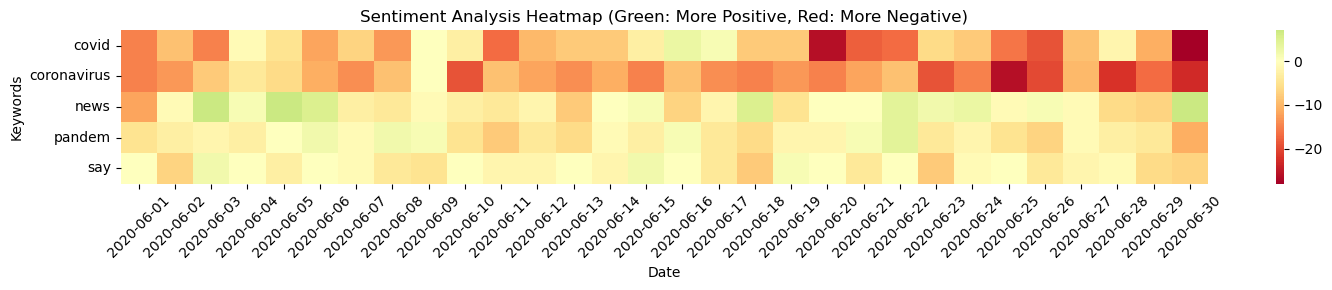

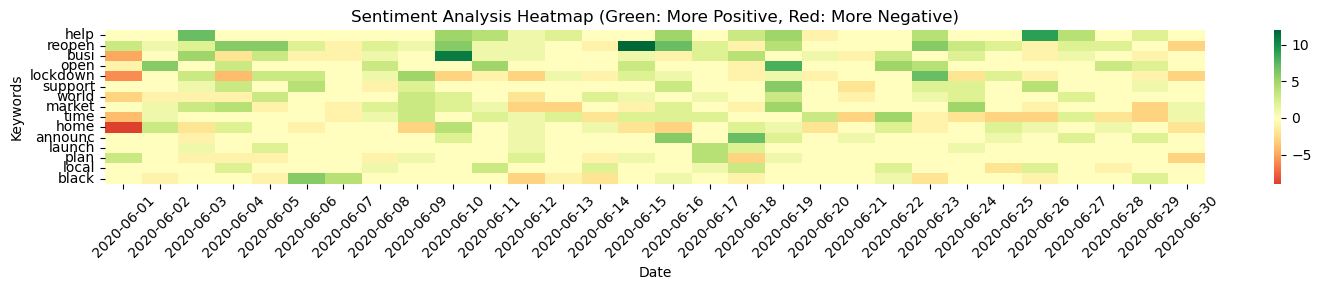

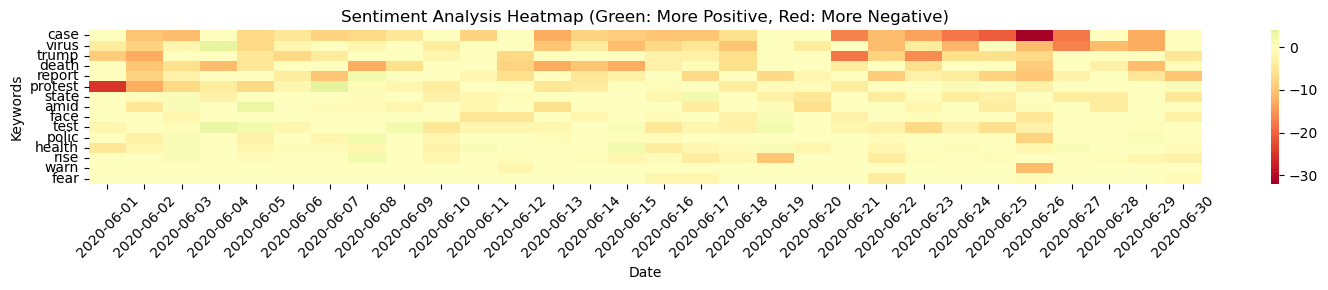

In [125]:
import pandas as pd
keywordListBoth = ['covid', 'coronavirus','news','pandem','say']
keywordListPos = ['help','reopen','busi','open','lockdown','support','world','market','time','home','announc','launch','plan','local','black']
keywordListNeg = ['case', 'virus','trump','death','report','protest','state','amid','face','test','polic','health','rise','warn','fear']
for keywordList in [keywordListBoth, keywordListPos, keywordListNeg]:

    keywordListStr = ','.join([f"'{word}'" for word in keywordList])
    result_dict = {}
    for keyword in keywordList:
        result_dict[keyword] = []

    for date in pd.date_range(start='2020-06-01', end='2020-06-30'):
        dateStr = date.strftime('%Y-%m-%d')
        cmd=f'''MATCH (p:POS)-[r:HAS_KEYWORD]->(k:Keyword)<-[:HAS_KEYWORD]-(n:NEG)
        where p.date = date("{dateStr}") and n.date = date("{dateStr}") AND k.name IN [{keywordListStr}]
        with k.name as key, count(DISTINCT p) AS POS, count(DISTINCT n) AS NEG
        return key, POS, NEG'''
        result = graph.run(cmd)
        
        # Initialize default values for this date
        date_results = {keyword: {'dateStr': dateStr, 'pos': 0, 'neg': 0} for keyword in keywordList}
        
        # Update with actual results
        for row in result:
            keyword = row['key']
            date_results[keyword]['pos'] = row['POS']
            date_results[keyword]['neg'] = row['NEG']
        
        # Add results to main dictionary
        for keyword in keywordList:
            result_dict[keyword].append(date_results[keyword])


    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Create data for heatmap
    dates = pd.date_range(start='2020-06-01', end='2020-06-30')
    keywords = keywordList

    # Initialize data matrix
    data_matrix = np.zeros((len(keywords), len(dates)))

    # Fill matrix with sentiment differences (pos - neg)
    for i, keyword in enumerate(keywords):
        for j, date in enumerate(dates):
            data = result_dict[keyword][j]
            sentiment_diff = data['pos'] - data['neg']
            data_matrix[i,j] = sentiment_diff

    # Create figure and axis
    plt.figure(figsize=(15, 3))

    # Create heatmap
    # Use RdYlGn colormap - red for negative, yellow for neutral, green for positive
    sns.heatmap(data_matrix, 
                xticklabels=[d.strftime('%Y-%m-%d') for d in dates],
                yticklabels=keywords,
                cmap='RdYlGn',
                center=0)  # Center the colormap at 0

    plt.title('Sentiment Analysis Heatmap (Green: More Positive, Red: More Negative)')
    plt.xlabel('Date')
    plt.ylabel('Keywords')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
